In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN, FasterRCNN_ResNet50_FPN_V2_Weights
import torch.optim as optim

In [2]:
model_weights_dir = '/Users/rishinigam/t81_588_course/deep_learning/Faster_RCNN/models_pretrained'

os.makedirs(model_weights_dir, exist_ok=True)
torch.hub.set_dir(model_weights_dir)

In [3]:
print(torch.backends.mps.is_available())

mps_device = torch.device("mps")

True


In [4]:
img_paths = f'../dataset_DL/BCCD_Dataset/BCCD/JPEGImages/'

In [5]:
full = pd.read_csv('../dataset_DL/BCCD_Dataset/raw_data.csv')
train = pd.read_csv('../dataset_DL/BCCD_Dataset/processed_csv/train.csv')
val = pd.read_csv('../dataset_DL/BCCD_Dataset/processed_csv/val.csv')
test = pd.read_csv('../dataset_DL/BCCD_Dataset/processed_csv/test.csv')

In [6]:
train.head()

,img_name,cell_type,x_min,x_max,y_min,y_max
0,BloodImage_00001.jpg,RBC,134,241,1,95
1,BloodImage_00001.jpg,RBC,346,449,26,138
2,BloodImage_00001.jpg,RBC,299,404,1,68
3,BloodImage_00001.jpg,RBC,1,98,38,164
4,BloodImage_00001.jpg,RBC,165,257,160,264


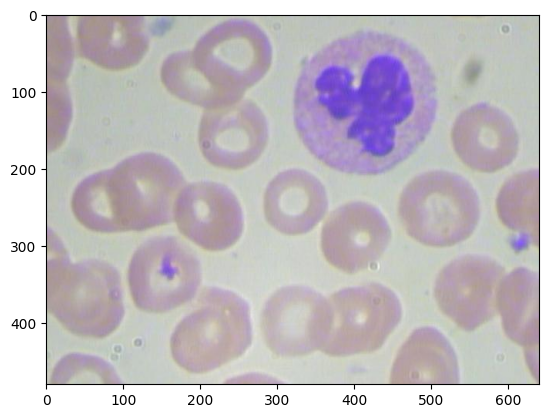

In [7]:
img = plt.imread('../dataset_DL/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00301.jpg')
plt.imshow(img)

In [8]:
train['img_name'].nunique(), val['img_name'].nunique(), test['img_name'].nunique()

(205, 87, 72)

In [9]:
train['cell_type'].value_counts(), val['cell_type'].value_counts()

(cell_type
 RBC          2382
 WBC           214
 Platelets     209
 Name: count, dtype: int64,
 cell_type
 RBC          968
 WBC           87
 Platelets     83
 Name: count, dtype: int64)

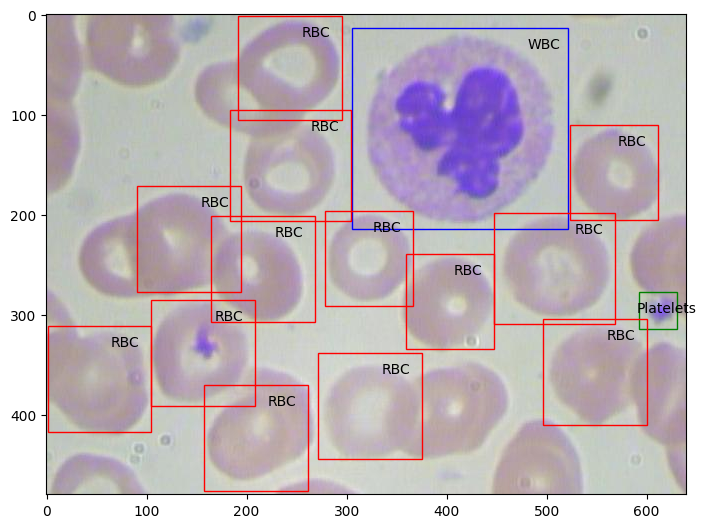

In [10]:
# img with detection (BB)
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

img = plt.imread('../dataset_DL/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00301.jpg')
plt.imshow(img)

for _, row in train[train.img_name == 'BloodImage_00301.jpg'].iterrows():
    x_min = row.x_min
    x_max = row.x_max
    y_min = row.y_min
    y_max = row.y_max

    w = x_max - x_min
    h = y_max - y_min

    if row.cell_type == 'RBC':
        edgecolor = 'r'
        ax.annotate('RBC', xy=(x_max-40,y_min+20))
    elif row.cell_type == 'WBC':
        edgecolor = 'b'
        ax.annotate('WBC', xy=(x_max-40,y_min+20))  
    elif row.cell_type == 'Platelets':
        edgecolor = 'g'
        ax.annotate('Platelets', xy=(x_max-40,y_min+20)) 

    # adding BB
    rect = patches.Rectangle((x_min, y_min), w, h, edgecolor=edgecolor, facecolor='none')

    ax.add_patch(rect)

### Modelling and data prepping
- Will use pytorch dataset and dataloader

In [11]:
class CellDataset(Dataset):
    def __init__(self, csv_file, root_dir,label_mapping,  transforms=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.label_mapping = label_mapping
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        # get image and its annotations
        img_name = self.annotations.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name)

        img = read_image(img_path).float() # check the float conversion

        # pick annotation for that particular file
        img_annotations = self.annotations[self.annotations['img_name'] == img_name]

        boxes = []
        labels = []

        for i in range(len(img_annotations)):
            x_min = img_annotations.iloc[i,2]
            x_max = img_annotations.iloc[i,3]
            y_min = img_annotations.iloc[i,4]
            y_max = img_annotations.iloc[i,5]
            label = img_annotations.iloc[i,1]

            if x_max > x_min and y_max > y_min:
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(self.label_mapping[label])
        
        if len(boxes) == 0:
            # Return empty target if no valid boxes
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        # converting to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        if self.transforms:
            img = self.transforms(img)
        return img, target

In [12]:
label_mapping = {
    "RBC": 1,
    "WBC": 2,
    "Platelets": 3
}

In [13]:
def collate_fn(batch):
    # Filter out None values from batch
    batch = [b for b in batch if b[1] is not None]
    imgs, targets = zip(*batch) if batch else ([], [])
    
    # Return images and targets
    return list(imgs), list(targets)

In [14]:
# dataloader
train_dataset = CellDataset(csv_file='../dataset_DL/BCCD_Dataset/processed_csv/train.csv', root_dir=img_paths, label_mapping=label_mapping)
val_dataset = CellDataset(csv_file='../dataset_DL/BCCD_Dataset/processed_csv/val.csv', root_dir=img_paths, label_mapping=label_mapping)
test_dataset = CellDataset(csv_file='../dataset_DL/BCCD_Dataset/processed_csv/test.csv', root_dir=img_paths, label_mapping=label_mapping)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [15]:
# model building
def get_model(num_classes):
    # loading model
    backbone = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
    backbone.out_channels = 2048

    model = FasterRCNN(backbone, num_classes)
    # replace classifer with a new one for the specific num of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = len(set(train_dataset.annotations['cell_type'])) + 1
model = get_model(num_classes)
model.to(mps_device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [16]:
# training loop

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.0005)

# training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for imgs, targets in train_loader:
        if imgs is None or targets is None:
            continue
        imgs = list(img.to(mps_device) for img in imgs)
        targets = [{k: v.to(mps_device) for k, v in t.items()} for t in targets]
        print(targets)
        # forward pass
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropogation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
    print(f'Epoch {epoch_loss / len(train_loader)}')

[{'boxes': tensor([[262., 401., 357., 480.],
        [239., 187., 329., 293.],
        [230.,  56., 305., 147.],
        [486., 255., 586., 367.],
        [448., 355., 541., 441.],
        [537., 403., 636., 480.],
        [396., 429., 495., 480.],
        [407.,  57., 519., 158.],
        [368., 258., 464., 361.],
        [303.,  62., 386., 163.],
        [579., 254., 628., 294.],
        [  4., 383., 101., 480.],
        [452., 147., 493., 186.],
        [ 63., 267., 287., 467.],
        [  1., 262.,  66., 378.],
        [315., 293., 408., 379.]], device='mps:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 2, 1, 1], device='mps:0')}]


AssertionError: targets should not be none when in training mode

In [ ]:
# import pandas as pd

# # Load dataset
# csv_file = '../dataset_DL/BCCD_Dataset/processed_csv/train.csv'
# root_dir = img_paths
# label_mapping = {
#     "RBC": 1,
#     "WBC": 2,
#     "Platelets": 3
# }

# dataset = CellDataset(csv_file=csv_file, root_dir=root_dir, label_mapping=label_mapping)

# # Iterate through the dataset and find rows with None targets
# for idx in range(len(dataset)):
#     img, target = dataset[idx]
#     if target is None:
#         img_name = dataset.annotations.iloc[idx, 0]
#         img_annotations = dataset.annotations[dataset.annotations['img_name'] == img_name]
#         print(f"Row with index {idx} has None target")
#         print(f"Image name: {img_name}")
#         print(f"Annotations: \n{img_annotations}")
